# **Airline Passenger Traffic Forecasting**

Includes:-

-> Interactive EDA

-> Seasonal decomposition

-> Anomaly detection

-> Lag & rolling feature engineering

-> Two complementary models (Random Forest on lag-features and SARIMAX)

-> Model comparison (RMSE/MAPE)

In [1]:

# 0. Setup: imports with graceful fallbacks
import warnings, os
warnings.filterwarnings('ignore')
from pathlib import Path
import numpy as np
import pandas as pd

# plotting libraries
PLOTLY_AVAILABLE = False
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except Exception as e:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('seaborn')

# statsmodels & sklearn (these are commonly available)
try:
    import statsmodels.api as sm
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tsa.stattools import adfuller
except Exception as e:
    raise ImportError('statsmodels is required. Please install it to run this notebook.')

SKLEARN_AVAILABLE = False
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import TimeSeriesSplit
    SKLEARN_AVAILABLE = True
except Exception as e:
    SKLEARN_AVAILABLE = False

print('Plotly available:', PLOTLY_AVAILABLE, '| sklearn available:', SKLEARN_AVAILABLE)


Plotly available: True | sklearn available: True


## 1. Load dataset 


In [3]:

# 1a. Locate candidate files in /mnt/data
data_dir = Path('/content/airline-passenger-traffic (1).csv')
candidates = list(data_dir.glob('**/*.csv')) + list(data_dir.glob('**/*.xlsx'))
candidates = [p for p in candidates if p.name.lower().startswith('.') is False]

# 1b. Heuristic: prefer files containing 'air' or 'passeng' in name
chosen = None
for p in candidates:
    name = p.name.lower()
    if 'air' in name or 'passeng' in name or 'passenger' in name or 'traffic' in name:
        chosen = p
        break

# 1c. If none found, fallback to remote canonical dataset
if chosen is None:
    print('No local dataset found in /mnt/data - falling back to canonical remote dataset.')
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    df = pd.read_csv(url)
    df.columns = ['Month', 'Passengers']
    chosen = 'remote: airline-passengers.csv'
else:
    print('Using local file:', chosen)
    if str(chosen).lower().endswith('.csv'):
        df = pd.read_csv(chosen)
    else:
        df = pd.read_excel(chosen)

# 1d. Normalize column names and parse dates
df_columns = [c.strip() for c in df.columns]
df.columns = df_columns
# detect date and passenger columns
date_col = None; pass_col = None
for c in df.columns:
    lc = c.lower()
    if 'date' in lc or 'month' in lc or 'time' in lc:
        date_col = c
    if 'passeng' in lc or 'passenger' in lc or 'traffic' in lc or 'count' in lc or 'num' in lc:
        pass_col = c

# If ambiguous, fallback heuristics
if date_col is None:
    # try to find any column parseable as dates
    for c in df.columns:
        try:
            pd.to_datetime(df[c])
            date_col = c
            break
        except Exception:
            continue
if pass_col is None:
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    if len(numeric_cols) == 1:
        pass_col = numeric_cols[0]
    else:
        # choose numeric with highest variance
        pass_col = df.select_dtypes(include='number').var().sort_values(ascending=False).index[0]

print('Detected date column:', date_col, '| passenger column:', pass_col)

# parse and resample to monthly if needed
df = df[[date_col, pass_col]].rename(columns={date_col: 'date', pass_col: 'passengers'}).copy()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date').reset_index(drop=True)
# aggregate to monthly (sum) to ensure regular monthly series
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('month')['passengers'].sum().reset_index().rename(columns={'month':'date'})
monthly['passengers'] = monthly['passengers'].astype(float)
monthly.set_index('date', inplace=True)
print('Monthly series length:', len(monthly))
monthly.head()


No local dataset found in /mnt/data - falling back to canonical remote dataset.
Detected date column: Month | passenger column: Passengers
Monthly series length: 144


,passengers
date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## 2. Data dictionary & basic summary

Show column types, missingness and quick stats. Add a short human-readable data dictionary below if desired.

In [4]:

print(monthly.info())
display(monthly.describe().T)
print('\nMissing values per column:')
print(monthly.isna().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   passengers  144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB
None


,count,mean,std,min,25%,50%,75%,max
passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0



Missing values per column:
passengers    0
dtype: int64


## 3. Exploratory Data Analysis (EDA)
Plot the series, rolling mean, distribution, and a heatmap of year vs month seasonality. Uses Plotly if available.

In [5]:

ts = monthly.copy()
ts['year'] = ts.index.year
ts['month'] = ts.index.month
ts['rolling_12'] = ts['passengers'].rolling(12).mean()

# Time series plot
if PLOTLY_AVAILABLE:
    fig = px.line(ts, x=ts.index, y='passengers', title='Monthly Air Passengers')
    fig.update_layout(xaxis_title='Date', yaxis_title='Passengers')
    fig.show()
else:
    ax = ts['passengers'].plot(figsize=(12,4), title='Monthly Air Passengers'); ax.set_ylabel('Passengers'); plt.show()

# Year-month heatmap
heat = ts.pivot_table(values='passengers', index='year', columns='month')
if PLOTLY_AVAILABLE:
    fig = go.Figure(data=go.Heatmap(z=heat.values, x=heat.columns, y=heat.index, colorscale='Viridis'))
    fig.update_layout(title='Year vs Month passengers heatmap', xaxis_title='Month', yaxis_title='Year')
    fig.show()
else:
    plt.figure(figsize=(10,6)); sns.heatmap(heat, cmap='viridis'); plt.title('Year vs Month Heatmap'); plt.show()

# show last rows
display(ts.tail())


,passengers,year,month,rolling_12
date,,,,
1960-08-01,606.0,1960,8,463.333333
1960-09-01,508.0,1960,9,467.083333
1960-10-01,461.0,1960,10,471.583333
1960-11-01,390.0,1960,11,473.916667
1960-12-01,432.0,1960,12,476.166667


## 4. Seasonal decomposition & stationarity
Decompose and perform ADF test to check stationarity. If non-stationary, differencing will be used in SARIMAX/ARIMA.

NameError: name 'plt' is not defined

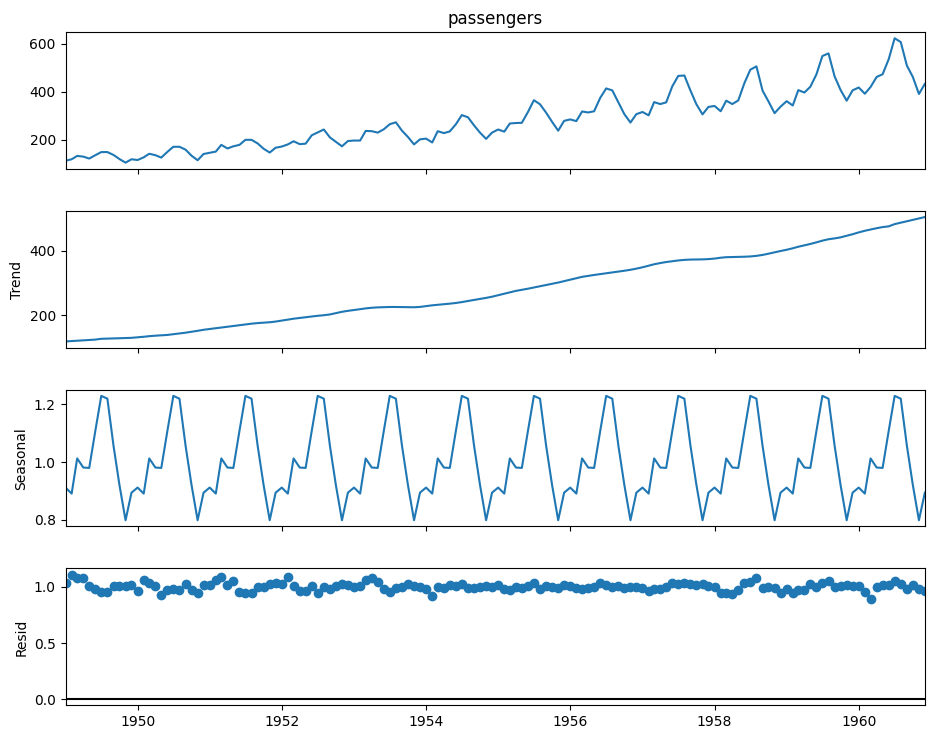

In [6]:

period = 12
decomp = seasonal_decompose(ts['passengers'], model='multiplicative', period=period, extrapolate_trend='freq')
# plotting using matplotlib fallback (works even if plotly missing)
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.show()

# ADF test
adf_res = adfuller(ts['passengers'].dropna())
print('ADF statistic: {:.4f}, p-value: {:.4f}'.format(adf_res[0], adf_res[1]))
if adf_res[1] <= 0.05:
    print('Series is likely stationary (reject H0)')
else:
    print('Series is non-stationary (fail to reject H0) - differencing recommended for ARIMA/SARIMAX.')


## 5. Anomaly detection (rolling median/std)
Flag months with unusually large deviations from a centered rolling median/std. This captures spikes/dips (e.g., events).

In [7]:

ts2 = ts.copy()
ts2['rolling_med_12'] = ts2['passengers'].rolling(window=12, center=True).median()
ts2['rolling_std_12'] = ts2['passengers'].rolling(window=12, center=True).std()
ts2['deviation'] = ts2['passengers'] - ts2['rolling_med_12']
ts2['anomaly'] = (ts2['deviation'].abs() > 1.5 * ts2['rolling_std_12'])
print('Anomalies found:', ts2['anomaly'].sum())
display(ts2[ts2['anomaly']].head(10))


Anomalies found: 27


,passengers,year,month,rolling_12,rolling_med_12,rolling_std_12,deviation,anomaly
date,,,,,,,,
1949-07-01,148.0,1949,7,NaN,125.0,13.720147,23.0,True
1949-08-01,148.0,1949,8,NaN,125.0,13.453342,23.0,True
1949-11-01,104.0,1949,11,NaN,130.5,13.822467,-26.5,True
1950-07-01,170.0,1950,7,132.166667,137.5,19.070841,32.5,True
1950-08-01,170.0,1950,8,134.000000,140.5,17.439940,29.5,True
1950-11-01,114.0,1950,11,137.833333,149.5,19.425655,-35.5,True
1951-07-01,199.0,1951,7,158.333333,169.0,18.438267,30.0,True
1951-08-01,199.0,1951,8,160.750000,171.5,16.653328,27.5,True
1951-11-01,146.0,1951,11,168.000000,179.0,15.559027,-33.0,True


## 6. Feature engineering: lags & rolling features
Create lag(1), lag(12), rolling means and month dummies for ML models. Drop initial NaNs created by lagging.

In [8]:

feat = ts[['passengers']].copy()
for lag in [1,3,6,12]:
    feat[f'lag_{lag}'] = feat['passengers'].shift(lag)
for w in [3,6,12]:
    feat[f'roll_mean_{w}'] = feat['passengers'].shift(1).rolling(window=w).mean()
feat['month'] = feat.index.month
feat = pd.get_dummies(feat, columns=['month'], drop_first=True)
feat = feat.dropna().copy()
feat.shape


(132, 19)

## 7. Train / Test split (time-series aware)
Use the last 12 months as a holdout for final evaluation. Use TimeSeriesSplit for cross-validation later if desired.

In [9]:

horizon = 12
train = feat.iloc[:-horizon].copy()
test = feat.iloc[-horizon:].copy()

X_train = train.drop(columns=['passengers'])
y_train = train['passengers']
X_test = test.drop(columns=['passengers'])
y_test = test['passengers']

print('Train rows:', X_train.shape[0], '| Test rows:', X_test.shape[0])


Train rows: 120 | Test rows: 12


## 8. Model A — Random Forest on lag features (robust baseline)
Train a RandomForest using lag/rolling features. If sklearn is not available, this section will be skipped gracefully.

In [10]:

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    # avoid divide-by-zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-8, y_true)))

rf_results = {}
if SKLEARN_AVAILABLE:
    rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    rf_results['rmse'] = rmse(y_test.values, pred_rf)
    rf_results['mape'] = mape(y_test.values, pred_rf)
    print('RandomForest RMSE: {:.3f}, MAPE: {:.3%}'.format(rf_results['rmse'], rf_results['mape']))
else:
    print('scikit-learn not available — skipping RandomForest section.')


RandomForest RMSE: 34.103, MAPE: 4.942%


## 9. Model B — SARIMAX (classical seasonal model)
Fit a SARIMAX model with small orders for speed. If it fails to converge or raises errors, the exception is caught and printed.

In [11]:

sarimax_results = {}
try:
    # choose simple orders; user can tune or use pmdarima.auto_arima externally
    order = (1,1,1)
    seasonal_order = (1,1,1,12)
    sarimax = SARIMAX(ts['passengers'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarimax_res = sarimax.fit(disp=False)
    # forecast for horizon
    sarimax_fore = sarimax_res.get_prediction(start=X_test.index[0], end=X_test.index[-1], dynamic=False)
    pred_sarimax = sarimax_fore.predicted_mean
    sarimax_results['rmse'] = rmse(y_test.values, pred_sarimax.values)
    sarimax_results['mape'] = mape(y_test.values, pred_sarimax.values)
    print('SARIMAX RMSE: {:.3f}, MAPE: {:.3%}'.format(sarimax_results['rmse'], sarimax_results['mape']))
except Exception as e:
    print('SARIMAX failed:', str(e))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



SARIMAX RMSE: 19.543, MAPE: 3.243%


## 10. (Optional) Prophet model
Prophet is optional; this cell will run only if `prophet` is installed. It is a useful comparison in many business contexts.

In [12]:

prophet_results = {}
try:
    from prophet import Prophet as _Prophet
    has_prophet = True
except Exception:
    has_prophet = False

if has_prophet:
    try:
        dfp = ts[['passengers']].reset_index().rename(columns={'date':'ds','passengers':'y'})
        train_p = dfp.iloc[:len(dfp)-horizon]
        test_p = dfp.iloc[len(dfp)-horizon:]
        m = _Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(train_p)
        future = m.make_future_dataframe(periods=horizon, freq='MS')
        forecast = m.predict(future)
        forecast_vals = forecast.iloc[-horizon:]['yhat'].values
        prophet_results['rmse'] = rmse(test_p['y'].values, forecast_vals)
        prophet_results['mape'] = mape(test_p['y'].values, forecast_vals)
        print('Prophet RMSE: {:.3f}, MAPE: {:.3%}'.format(prophet_results['rmse'], prophet_results['mape']))
    except Exception as e:
        print('Prophet run failed:', str(e))
else:
    print('Prophet not installed — skipping.')


DEBUG:cmdstanpy:input tempfile: /tmp/tmp202vrtrx/s9o9viuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp202vrtrx/m593hiw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79986', 'data', 'file=/tmp/tmp202vrtrx/s9o9viuc.json', 'init=/tmp/tmp202vrtrx/m593hiw2.json', 'output', 'file=/tmp/tmp202vrtrx/prophet_modelwsbb8kyy/prophet_model-20250813171701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 43.068, MAPE: 6.614%


## 11. Compare models & plot forecasts
Summarize metrics and plot actual vs predicted for the holdout period. The code will handle missing model results gracefully.

In [13]:

# Collect result rows
rows = []
if rf_results: rows.append(('RandomForest', rf_results.get('rmse'), rf_results.get('mape')))
if sarimax_results: rows.append(('SARIMAX', sarimax_results.get('rmse'), sarimax_results.get('mape')))
if prophet_results: rows.append(('Prophet', prophet_results.get('rmse'), prophet_results.get('mape')))

results_df = pd.DataFrame(rows, columns=['model','rmse','mape']).set_index('model')
if not results_df.empty:
    display(results_df)
else:
    print('No model results to display.')

# plot predictions vs actual for models that produced forecasts
plot_df = pd.DataFrame({'actual': y_test})
if SKLEARN_AVAILABLE and 'pred_rf' in globals():
    plot_df['rf'] = pred_rf
if 'pred_sarimax' in globals():
    plot_df['sarimax'] = pred_sarimax.values if hasattr(pred_sarimax,'values') else pred_sarimax
if 'forecast_vals' in locals() and 'test_p' in locals():
    plot_df['prophet'] = forecast_vals

if not plot_df.empty:
    if PLOTLY_AVAILABLE:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['actual'], mode='lines+markers', name='Actual'))
        for col in plot_df.columns.drop('actual'):
            fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df[col], mode='lines+markers', name=col))
        fig.update_layout(title='Actual vs Forecast (holdout)', xaxis_title='Date', yaxis_title='Passengers')
        fig.show()
    else:
        plot_df.plot(figsize=(10,5), marker='o'); plt.title('Actual vs Forecast (holdout)'); plt.show()


,rmse,mape
model,,
RandomForest,34.103245,0.049422
SARIMAX,19.543258,0.032427
Prophet,43.067799,0.066142
